In [41]:
import numpy as np
import chainer
from chainer import cuda,  Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain
import chainer.functions as F
import chainer.links as L
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
import pickle as pickle
from matplotlib import cm
%matplotlib inline 

In [60]:
mnist = fetch_mldata('MNIST original')
mnist.data   = mnist.data.astype(np.float32)
mnist.data  /= 255     # 0-1のデータに変換


In [61]:
def imshow_multi(x,c=5,r=5):
    fig=plt.figure(figsize=[15,15])
    for i in range(r*c):
        plt.subplot(r,c,i+1)
        plt.imshow(np.reshape(x[i,:],[28,28]))
        plt.gray()

        plt.tick_params(labelbottom='off')
        plt.tick_params(labelleft='off')

In [62]:
x_train = mnist.data
x_train = x_train.reshape(x_train.shape[0],1,28,28)

In [45]:
del mnist

In [46]:
class Decoder(chainer.Chain):
    def __init__(self):
        super(Decoder, self).__init__(
            l1=L.Linear(z_dim,512*3*3),
            dcv1=L.Deconvolution2D(in_channels=512,out_channels=256,ksize=2,stride=2,pad=1),
            dcv2=L.Deconvolution2D(in_channels=256,out_channels=128,ksize=2,stride=2,pad=1),
            dcv3=L.Deconvolution2D(in_channels=128,out_channels=64,ksize=2,stride=2,pad=1),
            dcv4=L.Deconvolution2D(in_channels=64,out_channels=1,ksize=3,stride=3,pad=1),
            bn1=L.BatchNormalization(size=512),
            bn2=L.BatchNormalization(size=256),
            bn3=L.BatchNormalization(size=128),
            bn4=L.BatchNormalization(size=64),
        )
    def __call__(self,z,train=True):
        x = F.reshape(self.l1(z),(z.data.shape[0],512,3,3))
        x=self.dcv1(F.relu(self.bn1(x)))
        x=self.dcv2(F.relu(self.bn2(x)))
        x=self.dcv3(F.relu(self.bn3(x)))
        x=self.dcv4(F.relu(self.bn4(x)))
        return F.sigmoid(x)
    

In [276]:
class Encoder(chainer.Chain):
    def __init__(self):
        super(Encoder,self).__init__(
            conv1=L.Convolution2D(in_channels=1,out_channels=64,ksize=3,stride=3,pad=1),
            conv2=L.Convolution2D(in_channels=64,out_channels=128,ksize=2,stride=2,pad=1),
            conv3=L.Convolution2D(in_channels=128,out_channels=256,ksize=2,stride=2,pad=1),
            conv4=L.Convolution2D(in_channels=256,out_channels=512,ksize=2,stride=2,pad=1),
            
            bc1=L.BatchNormalization(size=128),
            bc2=L.BatchNormalization(size=256),
            bc3=L.BatchNormalization(size=512),
            fc=L.Linear(3*3*512,z_dim * 2)
        )
    def __call__(self,x,train=True):
        h=F.relu((self.conv1(x)))
        h=F.relu(self.bc1(self.conv2(h)))
        h=F.relu(self.bc2(self.conv3(h)))
        h=F.relu(self.bc3(self.conv4(h)))
        #h=F.reshape(h,[x.data.shape[0],32])
        h=self.fc(h)
        
        return h
        


In [277]:
def var(x):
    return Variable(cuda.to_gpu(x.astype(np.float32)))
    
def var_int(x):
    return Variable(cuda.to_gpu(x.astype(np.int32)))
    

In [288]:
z_dim = 2

E=Encoder()
D=Decoder()

E.to_gpu()
D.to_gpu()

In [357]:

opt_e = optimizers.Adam(alpha=0.0002, beta1=0.5)
opt_d = optimizers.Adam(alpha=0.0002, beta1=0.5)
opt_e.setup(E)
opt_d.setup(D)
# opt_e.add_hook(chainer.optimizer.WeightDecay(0.0001))
# opt_d.add_hook(chainer.optimizer.WeightDecay(0.0001))


In [ ]:

bs=1000
ones = var(np.ones([bs,z_dim]))
lossE_hist=[]
lossD_hist=[]
for i in range(1000):
    if np.mod(i,10)==0:
        print i
    
    r=np.random.permutation(len(x_train))
    x=var(x_train[r[0:bs],:])
        
    z = E(x)

    z_sig = z[:,:z_dim]
    z_mu  = z[:,z_dim:]
    z = z_sig * np.random.randn() + z_mu

    y = D(z)

    temp = z_sig ** 2
    lossE = - 0.5 * F.mean(- temp + F.log(temp + 0.1**10) - z_mu**2 + ones) 
    lossD = - F.mean(x*F.log(y) + (1-x) * F.log(1-y))
    
    loss =  lossE + lossD

    E.cleargrads()
    D.cleargrads()

    loss.backward() 
    
    opt_e.update()
    opt_d.update()
    
    lossE_hist.append(lossE.data)
    lossD_hist.append(lossD.data)
        
#     print('----')
#     print(lossE.data)
#     print(lossD.data)
# plt.subplot(1,2,1)
# plt.plot(lossE_hist)
# plt.subplot(1,2,2)
# plt.plot(lossD_hist)

In [398]:
k=0
z_list = []
for k in range(10):
    t = mnist.target
    x_k = x_train[t == k][:100] #get 100 images from each class
    z_k = E(var(x_k))
    z_list.append(cuda.to_cpu(z_k.data))


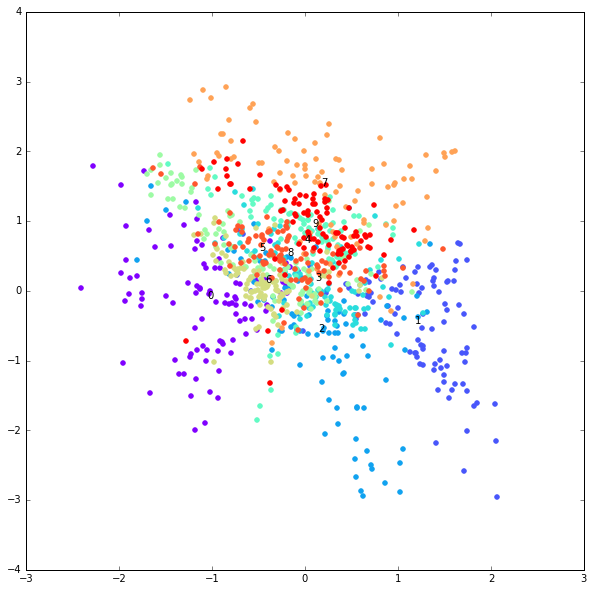

In [402]:
plt.figure(figsize=[10,10])
cmap = cm.rainbow(np.linspace(0,1,10))
for k,z in enumerate(z_list):
    mean = np.mean(z[:,z_dim:],axis=0)
    plt.text(mean[0],mean[1],k)
    plt.scatter(z[:,z_dim],z[:,z_dim+1],color = cmap[k])
plt.savefig('vae_latent.png')